# Capacity allocation

In [ ]:
#!python3 -m pip install -e /Users/david/PycharmProjects/robin

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
frame_capacity = {'1': 0.65, '2': 0.30, '3': 0.05, '4': 0}

n_services = 49
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 32, '2': 15, '3': 2, '4': 0}

In [4]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 49


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  32
RU2                  15
RU3                   2


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  49


In [7]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: services_by_ru[ru] / n_services * 100 for ru in services_by_ru}
print(frame_capacity)

{'RU1': 32, 'RU2': 15, 'RU3': 2}
{'RU1': 65.3061224489796, 'RU2': 30.612244897959183, 'RU3': 4.081632653061225}


/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


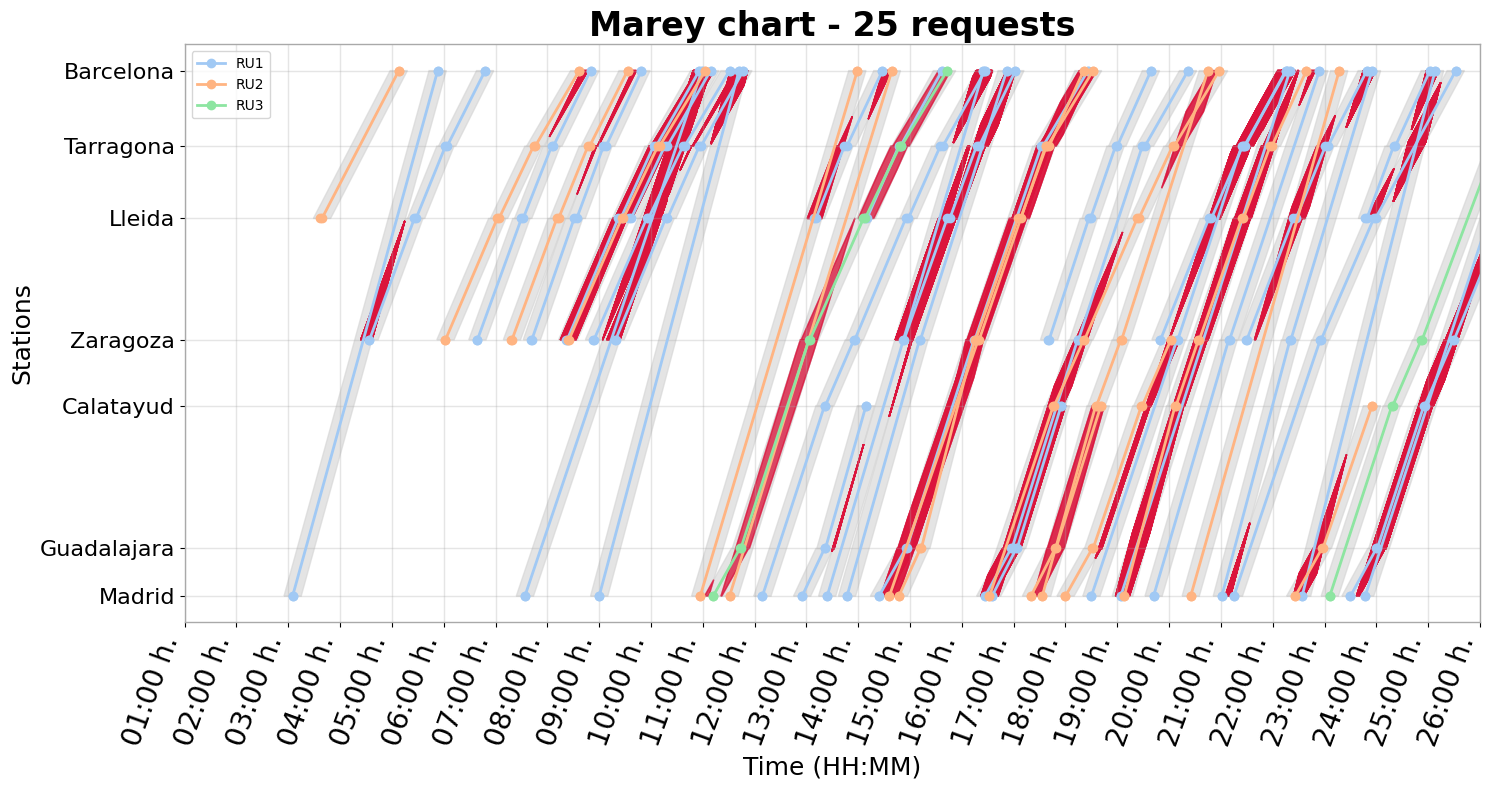

In [8]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [9]:
# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------
runs = 5
epochs = 100
pop_size = 50
seed_initializer = 29
fair_indices = ["Revenue", "Jain", "Gini", "Atkinson"]

# ------------------------------------------------------------------------------
# Data Collection Containers
# ------------------------------------------------------------------------------
# Lists to accumulate history and population data from each run.
history_data = []
population_data = []
population_real = [f'real_{i}' for i in range(pop_size)]
population_discrete = [f'discrete_{i}' for i in range(pop_size)]
population_columns = ['Run', 'FairIndex', 'Iteration'] + population_real + population_discrete

# ------------------------------------------------------------------------------
# 1. Iterate over Algorithms and Runs
# ------------------------------------------------------------------------------
for fair_index in fair_indices:
    # Reset random seed for reproducibility per algorithm
    np.random.seed(seed_initializer)
    print(f"Running {fair_index}")

    mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index=fair_index)

    # ------------------------------------------------------------------------------
    # 0. Problem Formulation
    # ------------------------------------------------------------------------------
    lb, ub = zip(*mptt.boundaries.real)
    problem = {
        "obj_func": mptt.objective_function,
        "bounds": IntegerVar(lb=lb, ub=ub),
        "minmax": "max",
        "save_population": True
    }

    for run in range(1, runs + 1):
        print(f"\tRun: {run}")
        run_seed = np.random.randint(0, 1000)

        # Initialize and run the optimizer with appropriate parameters.
        optimizer = GA.BaseGA(epoch=epochs, pop_size=pop_size)
        optimizer.solve(problem, seed=run_seed)

        # ---------------------------
        # Build History Data
        # ---------------------------
        for iteration, data in enumerate(optimizer.history.list_global_best):
            # Update schedule so that the latest heuristic schedule is available.
            mptt.update_schedule(data.solution)

            # Build a dictionary for this iteration
            history_data.append({
                "Run": run,
                "FairIndex": fair_index,
                "Iteration": iteration,
                "Fitness": data.target.fitness,
                "ExecutionTime": optimizer.history.list_epoch_time[iteration],
                "Discrete": mptt.get_heuristic_schedule_new() if fair_index != "Revenue" else mptt.get_heuristic_schedule_old(),
                "Real": data.solution,
                "Diversity": optimizer.history.list_diversity[iteration],
                "Exploitation": optimizer.history.list_exploitation[iteration],
                "Exploration": optimizer.history.list_exploration[iteration],
            })

        # ---------------------------
        # Build Population Data
        # ---------------------------
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_dict = {"Run": run, "FairIndex": fair_index, "Iteration": i}
            # Aquí usamos un contador 'j' para indexar cada individuo en el pop_epoch
            for j, individual in enumerate(pop_epoch):
                mptt.update_schedule(individual.solution)
                population_dict[f'real_{j}'] = individual.solution
                population_dict[f'discrete_{j}'] = (mptt.get_heuristic_schedule_new()
                                                    if fair_index != "Revenue"
                                                    else mptt.get_heuristic_schedule_old())
            population_data.append(population_dict)

# ------------------------------------------------------------------------------
# 2. Build Final DataFrames
# ------------------------------------------------------------------------------
# Create the history DataFrame from the list of dictionaries.
df_history = pd.DataFrame(history_data)
# Optionally, enforce a specific column order:
df_history = df_history[[
    "Run", "FairIndex", "Iteration", "Fitness", "ExecutionTime",
    "Discrete", "Real", "Diversity", "Exploitation", "Exploration"
]]

df_population = pd.DataFrame(population_data)
df_population = df_population[population_columns]

2025/02/19 01:51:42 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Revenue
	Run: 1


2025/02/19 01:51:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2933.65059306725, Global best: 2933.65059306725, Runtime: 0.97024 seconds
2025/02/19 01:51:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3147.7429350558236, Global best: 3147.7429350558236, Runtime: 0.98122 seconds
2025/02/19 01:51:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3299.504174397559, Global best: 3299.504174397559, Runtime: 0.98095 seconds
2025/02/19 01:51:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3700.6701859429068, Global best: 3700.6701859429068, Runtime: 0.97568 seconds
2025/02/19 01:51:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 4250.862309922815, Global best: 4250.862309922815, Runtime: 0.98838 seconds
2025/02/19 01:51:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

	Run: 2


2025/02/19 01:54:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2697.9085134520883, Global best: 2697.9085134520883, Runtime: 0.96143 seconds
2025/02/19 01:54:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3601.5328712066603, Global best: 3601.5328712066603, Runtime: 0.96496 seconds
2025/02/19 01:54:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3868.439126748302, Global best: 3868.439126748302, Runtime: 0.96738 seconds
2025/02/19 01:54:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3770.6839100173406, Global best: 3868.439126748302, Runtime: 0.96360 seconds
2025/02/19 01:54:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 4329.143009330772, Global best: 4329.143009330772, Runtime: 0.97288 seconds
2025/02/19 01:54:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

	Run: 3


2025/02/19 01:57:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2680.745790106342, Global best: 2680.745790106342, Runtime: 0.96637 seconds
2025/02/19 01:57:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3192.847933125688, Global best: 3192.847933125688, Runtime: 0.96985 seconds
2025/02/19 01:57:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3705.001302383286, Global best: 3705.001302383286, Runtime: 1.10119 seconds
2025/02/19 01:57:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 4032.41838827178, Global best: 4032.41838827178, Runtime: 0.97491 seconds
2025/02/19 01:57:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3878.1157802176235, Global best: 4032.41838827178, Runtime: 0.98155 seconds
2025/02/19 01:57:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, 

	Run: 4


2025/02/19 02:00:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2365.7918920106717, Global best: 2365.7918920106717, Runtime: 0.96005 seconds
2025/02/19 02:00:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2968.9505741810563, Global best: 2968.9505741810563, Runtime: 0.96091 seconds
2025/02/19 02:00:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3104.7472952562, Global best: 3104.7472952562, Runtime: 0.96432 seconds
2025/02/19 02:00:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3447.3449939710076, Global best: 3447.3449939710076, Runtime: 0.96696 seconds
2025/02/19 02:00:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3834.903493214015, Global best: 3834.903493214015, Runtime: 0.96801 seconds
2025/02/19 02:00:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

	Run: 5


2025/02/19 02:03:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2548.587361819045, Global best: 2548.587361819045, Runtime: 0.95517 seconds
2025/02/19 02:03:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2776.418072702622, Global best: 2776.418072702622, Runtime: 0.96343 seconds
2025/02/19 02:03:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3371.275679574405, Global best: 3371.275679574405, Runtime: 0.96073 seconds
2025/02/19 02:03:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3704.0931706052397, Global best: 3704.0931706052397, Runtime: 0.95535 seconds
2025/02/19 02:03:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3782.0897200560853, Global best: 3782.0897200560853, Runtime: 0.96694 seconds
2025/02/19 02:03:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

Running Jain
	Run: 1


2025/02/19 02:06:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2547.1777641459107, Global best: 2561.143625559168, Runtime: 1.01900 seconds
2025/02/19 02:06:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2752.9774231237216, Global best: 2752.9774231237216, Runtime: 1.01351 seconds
2025/02/19 02:06:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2684.0237075599953, Global best: 2752.9774231237216, Runtime: 1.01663 seconds
2025/02/19 02:06:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2885.8450415425677, Global best: 2885.8450415425677, Runtime: 1.01587 seconds
2025/02/19 02:06:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3008.703785064416, Global best: 3008.703785064416, Runtime: 1.00877 seconds
2025/02/19 02:06:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

	Run: 2


2025/02/19 02:09:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2428.352237857588, Global best: 2884.973454779206, Runtime: 1.00897 seconds
2025/02/19 02:09:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2549.4108185754717, Global best: 2884.973454779206, Runtime: 1.01039 seconds
2025/02/19 02:10:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2699.047652132631, Global best: 2884.973454779206, Runtime: 1.01347 seconds
2025/02/19 02:10:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2692.0295844650564, Global best: 2884.973454779206, Runtime: 1.01024 seconds
2025/02/19 02:10:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2908.968743603335, Global best: 2908.968743603335, Runtime: 1.00442 seconds
2025/02/19 02:10:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

	Run: 3


2025/02/19 02:13:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2113.5001547956826, Global best: 2218.9041360245506, Runtime: 1.01657 seconds
2025/02/19 02:13:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2588.953185136791, Global best: 2588.953185136791, Runtime: 1.01869 seconds
2025/02/19 02:13:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2807.9037870095226, Global best: 2807.9037870095226, Runtime: 1.01816 seconds
2025/02/19 02:13:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2474.5559839771986, Global best: 2807.9037870095226, Runtime: 1.01289 seconds
2025/02/19 02:13:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3188.920144986554, Global best: 3188.920144986554, Runtime: 1.02341 seconds
2025/02/19 02:13:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 4


2025/02/19 02:16:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2633.095118025256, Global best: 2633.095118025256, Runtime: 1.01695 seconds
2025/02/19 02:16:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2672.3813963011066, Global best: 2672.3813963011066, Runtime: 1.02094 seconds
2025/02/19 02:16:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2737.5853970910625, Global best: 2737.5853970910625, Runtime: 1.02153 seconds
2025/02/19 02:16:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2874.7938062710978, Global best: 2874.7938062710978, Runtime: 1.02698 seconds
2025/02/19 02:16:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3203.725852642204, Global best: 3203.725852642204, Runtime: 1.02654 seconds
2025/02/19 02:16:27 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 5


2025/02/19 02:19:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2269.7442394239883, Global best: 2269.7442394239883, Runtime: 1.01228 seconds
2025/02/19 02:19:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2269.7442394239883, Global best: 2269.7442394239883, Runtime: 1.02265 seconds
2025/02/19 02:19:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2436.8167854629532, Global best: 2436.8167854629532, Runtime: 1.02350 seconds
2025/02/19 02:19:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3052.9158621973756, Global best: 3052.9158621973756, Runtime: 1.02321 seconds
2025/02/19 02:19:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2983.7712322204416, Global best: 3052.9158621973756, Runtime: 1.02223 seconds
2025/02/19 02:19:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

Running Gini
	Run: 1


2025/02/19 02:22:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2364.4481681189336, Global best: 2385.2129045545835, Runtime: 1.02961 seconds
2025/02/19 02:22:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2581.550401049058, Global best: 2581.550401049058, Runtime: 1.02863 seconds
2025/02/19 02:22:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2771.1966015365065, Global best: 2771.1966015365065, Runtime: 1.03298 seconds
2025/02/19 02:22:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2771.1966015365065, Global best: 2771.1966015365065, Runtime: 1.02657 seconds
2025/02/19 02:22:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3143.151028910376, Global best: 3143.151028910376, Runtime: 1.02804 seconds
2025/02/19 02:22:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 2


2025/02/19 02:26:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2328.9842528683284, Global best: 2676.797137250167, Runtime: 1.02166 seconds
2025/02/19 02:26:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2508.3785846107144, Global best: 2676.797137250167, Runtime: 1.03480 seconds
2025/02/19 02:26:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2701.66345981217, Global best: 2701.66345981217, Runtime: 1.03179 seconds
2025/02/19 02:26:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3100.0912955115314, Global best: 3100.0912955115314, Runtime: 1.03372 seconds
2025/02/19 02:26:05 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3148.311046959581, Global best: 3148.311046959581, Runtime: 1.03630 seconds
2025/02/19 02:26:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

	Run: 3


2025/02/19 02:29:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2435.6492621576285, Global best: 2435.6492621576285, Runtime: 1.02157 seconds
2025/02/19 02:29:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2462.8615198067714, Global best: 2462.8615198067714, Runtime: 1.01935 seconds
2025/02/19 02:29:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2327.1535629959094, Global best: 2462.8615198067714, Runtime: 1.03058 seconds
2025/02/19 02:29:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2858.2707470334467, Global best: 2858.2707470334467, Runtime: 1.03754 seconds
2025/02/19 02:29:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2834.6756379408657, Global best: 2858.2707470334467, Runtime: 1.04495 seconds
2025/02/19 02:29:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run: 4


2025/02/19 02:32:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2426.7518894726545, Global best: 2426.7518894726545, Runtime: 1.02921 seconds
2025/02/19 02:32:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2742.4947689416645, Global best: 2742.4947689416645, Runtime: 1.04040 seconds
2025/02/19 02:32:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2742.4947689416645, Global best: 2742.4947689416645, Runtime: 1.03558 seconds
2025/02/19 02:32:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2844.918066081487, Global best: 2844.918066081487, Runtime: 1.03378 seconds
2025/02/19 02:32:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3309.282660863334, Global best: 3309.282660863334, Runtime: 1.02787 seconds
2025/02/19 02:32:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 5


2025/02/19 02:35:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2167.7966996281284, Global best: 2167.7966996281284, Runtime: 1.02408 seconds
2025/02/19 02:35:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2187.216071125348, Global best: 2187.216071125348, Runtime: 1.02385 seconds
2025/02/19 02:35:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2222.925093983952, Global best: 2222.925093983952, Runtime: 1.02803 seconds
2025/02/19 02:35:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2640.313347063844, Global best: 2640.313347063844, Runtime: 1.03284 seconds
2025/02/19 02:35:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2840.377615544129, Global best: 2840.377615544129, Runtime: 1.03519 seconds
2025/02/19 02:35:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

Running Atkinson
	Run: 1


2025/02/19 02:38:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2479.4582601596258, Global best: 2697.8131051162018, Runtime: 1.02284 seconds
2025/02/19 02:39:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2870.5075493242357, Global best: 2870.5075493242357, Runtime: 1.03633 seconds
2025/02/19 02:39:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2930.955685017855, Global best: 2930.955685017855, Runtime: 1.03560 seconds
2025/02/19 02:39:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3164.0932483732595, Global best: 3164.0932483732595, Runtime: 1.03733 seconds
2025/02/19 02:39:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3539.864938613406, Global best: 3539.864938613406, Runtime: 1.03539 seconds
2025/02/19 02:39:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 2


2025/02/19 02:42:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2743.1352118303457, Global best: 2785.8214145251823, Runtime: 1.01972 seconds
2025/02/19 02:42:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2721.9245326733085, Global best: 2785.8214145251823, Runtime: 1.02461 seconds
2025/02/19 02:42:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3194.7351914432115, Global best: 3194.7351914432115, Runtime: 1.02904 seconds
2025/02/19 02:42:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3403.9368959322096, Global best: 3403.9368959322096, Runtime: 1.02984 seconds
2025/02/19 02:42:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3419.032808139783, Global best: 3419.032808139783, Runtime: 1.03073 seconds
2025/02/19 02:42:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 3


2025/02/19 02:45:29 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 3055.868876716972, Global best: 3055.868876716972, Runtime: 1.01344 seconds
2025/02/19 02:45:30 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2768.6530589542676, Global best: 3055.868876716972, Runtime: 1.02659 seconds
2025/02/19 02:45:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3222.1443687542146, Global best: 3222.1443687542146, Runtime: 1.03192 seconds
2025/02/19 02:45:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3173.9898070093, Global best: 3222.1443687542146, Runtime: 1.03494 seconds
2025/02/19 02:45:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3185.669621420134, Global best: 3222.1443687542146, Runtime: 1.04021 seconds
2025/02/19 02:45:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch

	Run: 4


2025/02/19 02:48:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2771.057739255252, Global best: 2771.057739255252, Runtime: 1.02642 seconds
2025/02/19 02:48:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2768.1547034267005, Global best: 2771.057739255252, Runtime: 1.02862 seconds
2025/02/19 02:48:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2829.987400859633, Global best: 2829.987400859633, Runtime: 1.03581 seconds
2025/02/19 02:48:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2890.187184539824, Global best: 2890.187184539824, Runtime: 1.03746 seconds
2025/02/19 02:48:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3106.3612718823792, Global best: 3106.3612718823792, Runtime: 1.03869 seconds
2025/02/19 02:48:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch

	Run: 5


2025/02/19 02:51:57 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2443.90851352698, Global best: 2443.90851352698, Runtime: 1.02246 seconds
2025/02/19 02:51:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2443.90851352698, Global best: 2443.90851352698, Runtime: 1.02682 seconds
2025/02/19 02:51:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2950.1753853793516, Global best: 2950.1753853793516, Runtime: 1.03066 seconds
2025/02/19 02:52:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3014.4635929639358, Global best: 3014.4635929639358, Runtime: 1.02337 seconds
2025/02/19 02:52:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3425.820240825251, Global best: 3425.820240825251, Runtime: 1.01996 seconds
2025/02/19 02:52:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy/')

In [11]:
df_history.to_csv(reports_path / 'df_history_equity_19_feb_25_full.csv', sep=";", index=False)

In [12]:
df_population.to_csv(reports_path / 'df_population_equity_19_feb_25_full.csv', sep=";", index=False)

In [13]:
df_history = pd.read_csv(reports_path / 'df_history_equity_19_feb_25_full.csv', sep=";")
df_population = pd.read_csv(reports_path / 'df_population_equity_19_feb_25_full.csv', sep=";")

In [34]:
df_history

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,2933.650593,0.989638,[ True True False True False False False Tr...,[1041. 1114. 1146. 1409. 1441. 1502. 1533. 159...,11.873798,0.000000,100.000000
1,1,Revenue,1,3147.742935,1.007445,[ True True True True False False False Tr...,[1006. 1114. 1147. 1409. 1449. 1497. 1539. 159...,10.012093,15.679106,84.320894
2,1,Revenue,2,3299.504174,1.011258,[ True True False True False False False Tr...,[1061. 1114. 1146. 1430. 1449. 1498. 1538. 159...,7.631318,35.729768,64.270232
3,1,Revenue,3,3700.670186,0.994919,[ True True True True False False False Tr...,[1041. 1114. 1147. 1409. 1441. 1497. 1539. 159...,6.515349,45.128352,54.871648
4,1,Revenue,4,4250.862310,1.000474,[ True True True True False False False Tr...,[1041. 1114. 1146. 1409. 1441. 1497. 1539. 159...,5.653798,52.384248,47.615752
...,...,...,...,...,...,...,...,...,...,...
495,5,Revenue,95,6583.355513,0.992179,[ True True True True False False False Tr...,[1052. 1109. 1140. 1446. 1445. 1505. 1533. 159...,3.234884,73.441020,26.558980
496,5,Revenue,96,6583.355513,0.986967,[ True True True True False False False Tr...,[1052. 1109. 1140. 1446. 1445. 1505. 1533. 159...,3.197364,73.749061,26.250939
497,5,Revenue,97,6583.355513,0.986680,[ True True True True False False False Tr...,[1052. 1109. 1140. 1446. 1445. 1505. 1533. 159...,3.249767,73.318822,26.681178
498,5,Revenue,98,6583.355513,0.990955,[ True True True True False False False Tr...,[1052. 1109. 1140. 1446. 1445. 1505. 1533. 159...,3.239380,73.404106,26.595894


In [19]:
df_population

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,[1041. 1114. 1146. 1409. 1441. 1502. 1533. 159...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Revenue,1,NaN,[1041. 1111. 1142. 1409. 1445. 1500. 1533. 159...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Revenue,2,NaN,NaN,[1120. 1115. 1146. 1466. 1445. 1502. 1530. 159...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Revenue,3,NaN,NaN,NaN,[1041. 1109. 1142. 1409. 1449. 1500. 1537. 159...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Revenue,4,NaN,NaN,NaN,NaN,[1061. 1114. 1147. 1430. 1445. 1498. 1538. 159...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,Revenue,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,5,Revenue,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,5,Revenue,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,5,Revenue,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1090.0, 1109.0, 1147.0, 1409.0, 1445.0, 1500....","[1061.0, 1114.0, 1146.0, 1378.0, 1449.0, 1497....","[1082.0, 1114.0, 1147.0, 1378.0, 1450.0, 1499....","[1087.0, 1114.0, 1146.0, 1430.0, 1449.0, 1498....","[1019.0, 1112.0, 1144.0, 1449.0, 1450.0, 1504....","[1007.0, 1115.0, 1142.0, 1466.0, 1445.0, 1499....","[1082.0, 1114.0, 1142.0, 1378.0, 1449.0, 1497....",...,[ True True False True True False False Tr...,[ True True False True False False False Fal...,[ True True True True True False False Fal...,[ True True False True True False False Tr...,[ True True True True False False False Tr...,[False True False True False False False Tr...,[ True True True True False False False Tr...,[ True True False True False False False Tr...,[ True True True True False False False Tr...,[ True True False True False False False Tr...
1,1,Revenue,1,"[1021.0, 1110.0, 1145.0, 1389.0, 1449.0, 1497....","[1110.0, 1114.0, 1146.0, 1417.0, 1441.0, 1505....","[1082.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1050.0, 1114.0, 1147.0, 1440.0, 1450.0, 1498....","[1041.0, 1111.0, 1142.0, 1417.0, 1441.0, 1501....","[1059.0, 1112.0, 1147.0, 1422.0, 1441.0, 1501....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1500....",...,[ True True True True True False False Tr...,[ True True False True False False False Tr...,[ True True False True False False False Fal...,[ True True True True False False False Tr...,[False True True True False False False Fal...,[ True True False True False False False Tr...,[ True True True True False False False Tr...,[ True True False True False False False Tr...,[ True True True True False False False Tr...,[ True True False True False False False Tr...
2,1,Revenue,2,"[1041.0, 1114.0, 1141.0, 1417.0, 1441.0, 1502....","[1061.0, 1109.0, 1140.0, 1417.0, 1441.0, 1500....","[1061.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1430.0, 1449.0, 1498....","[1061.0, 1114.0, 1147.0, 1430.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1498....","[1041.0, 1109.0, 1142.0, 1417.0, 1441.0, 1500....",...,[ True True True True False False False Fal...,[ True True False True False False False Tr...,[ True True True True True False False Tr...,[ True True False True False False False Tr...,[ True True False True False False False Tr...,[ True True False False True False False Fal...,[ True True True True False False False Tr...,[ True True False True False False False Tr...,[ True True True True False False False Fal...,[False True False True False False False Tr...
3,1,Revenue,3,"[1082.0, 1114.0, 1147.0, 1409.0, 1449.0, 1500....","[1061.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1147.0, 1436.0, 1449.0, 1502....","[1061.0, 1114.0, 1146.0, 1417.0, 1449.0, 1497....","[1041.0, 1114.0, 1147.0, 1409.0, 1441.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1142.0, 1409.0, 1441.0, 1497....",...,[ True True True True False False False Tr...,[False True True True False False False Tr...,[ True True False True False False False Tr...,[ True True True True False False False Tr...,[ True True False True False False False Tr...,[ True True False True False False False Tr...,[ True True False True True False False Tr...,[ True True True True False False False Tr...,[ True True True True False False False Tr...,[ True True True True True False False Tr...
4,1,Revenue,4,"[1041.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1147.0, 1409.0, 1442.0, 1498....","[1041.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1041.0, 1114.0, 1146.0, 1409.0, 1441.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1497....",...,[ True True True True False Fal

In [15]:
columns_to_transform = df_population.filter(like="discrete_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(lambda x: 1 if x == "True" else 0, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1090.0, 1109.0, 1147.0, 1409.0, 1445.0, 1500....","[1061.0, 1114.0, 1146.0, 1378.0, 1449.0, 1497....","[1082.0, 1114.0, 1147.0, 1378.0, 1450.0, 1499....","[1087.0, 1114.0, 1146.0, 1430.0, 1449.0, 1498....","[1019.0, 1112.0, 1144.0, 1449.0, 1450.0, 1504....","[1007.0, 1115.0, 1142.0, 1466.0, 1445.0, 1499....","[1082.0, 1114.0, 1142.0, 1378.0, 1449.0, 1497....",...,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
1,1,Revenue,1,"[1021.0, 1110.0, 1145.0, 1389.0, 1449.0, 1497....","[1110.0, 1114.0, 1146.0, 1417.0, 1441.0, 1505....","[1082.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1050.0, 1114.0, 1147.0, 1440.0, 1450.0, 1498....","[1041.0, 1111.0, 1142.0, 1417.0, 1441.0, 1501....","[1059.0, 1112.0, 1147.0, 1422.0, 1441.0, 1501....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1500....",...,"[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
2,1,Revenue,2,"[1041.0, 1114.0, 1141.0, 1417.0, 1441.0, 1502....","[1061.0, 1109.0, 1140.0, 1417.0, 1441.0, 1500....","[1061.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1430.0, 1449.0, 1498....","[1061.0, 1114.0, 1147.0, 1430.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1498....","[1041.0, 1109.0, 1142.0, 1417.0, 1441.0, 1500....",...,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,1,Revenue,3,"[1082.0, 1114.0, 1147.0, 1409.0, 1449.0, 1500....","[1061.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1147.0, 1436.0, 1449.0, 1502....","[1061.0, 1114.0, 1146.0, 1417.0, 1449.0, 1497....","[1041.0, 1114.0, 1147.0, 1409.0, 1441.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1142.0, 1409.0, 1441.0, 1497....",...,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,Revenue,4,"[1041.0, 1114.0, 1147.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1146.0, 1409.0, 1449.0, 1497....","[1061.0, 1114.0, 1147.0

In [22]:
import itertools

from src.timetabling_problem import MPTT

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

top_3_algos = ("Revenue", "Jain", "Gini", "Atkinson")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['FairIndex'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["FairIndex"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'real' in col], inplace=True)


# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

def jain_index_from_discrete(scheduled) -> float:
    return mptt.jain_fairness_index(scheduled, mptt.capacities)[0]

def pairwise_diff_from_discrete(scheduled_trains_array) -> float:
    # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
    importance_dict = mptt.sum_importance(scheduled_trains_array)
    importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

    # Calcular la suma de diferencias absolutas pairwise entre las importancias.
    pairwise_diff = 0
    for ru1, ru2 in itertools.combinations(ru_names, 2):
        pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

    return pairwise_diff
# Iterate through the dataframe and apply the function with progress feedback
discrete_columns = df_pop.columns[df_pop.columns.str.contains('discrete_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['FairIndex']
    real_solution = row

    # Print message if there's a change in 'Run' or 'FairIndex'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, FairIndex = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, discrete_columns] = row[discrete_columns].map(pairwise_diff_from_discrete)

print("Processing completed.")
df_pop

Filtered algos: {'Jain', 'Gini', 'Revenue', 'Atkinson'}
Processing new combination: Run = 1, FairIndex = Revenue
Processing new combination: Run = 2, FairIndex = Revenue
Processing new combination: Run = 3, FairIndex = Revenue
Processing new combination: Run = 4, FairIndex = Revenue
Processing new combination: Run = 5, FairIndex = Revenue
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Pro

,Run,FairIndex,Iteration,discrete_0,discrete_1,discrete_2,discrete_3,discrete_4,discrete_5,discrete_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,1.397147,1.170169,1.373813,1.580903,1.387704,0.396077,0.495685,...,0.360434,0.501384,0.687271,0.170056,0.994426,1.479072,0.143573,0.162778,0.244726,0.270925
1,1,Revenue,1,0.518388,1.400932,1.170169,0.994426,0.348109,0.39493,1.170169,...,1.030269,0.241119,0.373042,1.170169,0.574198,1.318627,1.106152,0.261287,0.164109,1.304587
2,1,Revenue,2,0.314128,0.163152,1.27439,1.246054,1.246054,0.479435,0.504108,...,1.287407,1.280074,1.148876,0.332921,1.313143,0.518388,1.125885,1.182037,0.503697,1.361951
3,1,Revenue,3,0.366902,0.154517,1.106152,1.154221,1.125885,0.013398,1.182037,...,1.134442,0.344853,1.304587,1.184418,1.246054,1.182037,1.148876,1.148876,0.179488,1.319605
4,1,Revenue,4,1.061869,0.261287,1.233445,0.352653,1.061869,1.125885,0.352653,...,1.170169,1.061869,1.290338,1.347344,0.280362,1.191676,1.246054,1.260303,0.280362,1.290338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,0.021656,0.035715,0.021656,0.021656,0.021656,0.028164,0.021656,...,0.021656,0.021656,0.099794,0.021656,0.021656,0.021656,0.021656,0.028164,0.035341,0.015972
1996,5,Atkinson,96,0.030786,0.021656,0.021656,0.021656,0.021656,0.021656,0.021656,...,0.035377,0.065353,0.021656,0.021656,0.021656,0.021656,0.021656,0.021656,0.035377,0.015972
1997,5,Atkinson,97,0.021656,0.021656,0.021656,0.021656,0.021656,0.015972,0.021656,...,0.021656,0.021656,0.021656,0.021656,0.021656,0.021656,0.015972,0.065353,0.065353,0.021656
1998,5,Atkinson,98,0.021656,0.017065,0.107198,0.043894,0.099794,0.021656,0.05955,...,0.021656,0.035715,0.021656,0.015972,0.021656,0.014435,0.015972,0.055821,0.021656,0.021656


In [23]:
# Save df_pop
#df_pop.to_csv(reports_path / 'df_pop_equity.csv', sep=";", index=False)
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['FairIndex']

    for individual in [ind_name for ind_name in row[1].index if 'discrete' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'FairIndex': algo,
                     'Individual': f'ID_{individual}'})

df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,FairIndex,Individual
0,1,0,1.397147,Revenue,ID_discrete_0
1,1,0,1.170169,Revenue,ID_discrete_1
2,1,0,1.373813,Revenue,ID_discrete_2
3,1,0,1.580903,Revenue,ID_discrete_3
4,1,0,1.387704,Revenue,ID_discrete_4
...,...,...,...,...,...
99995,5,99,0.021656,Atkinson,ID_discrete_45
99996,5,99,0.021656,Atkinson,ID_discrete_46
99997,5,99,0.021656,Atkinson,ID_discrete_47
99998,5,99,0.021656,Atkinson,ID_discrete_48


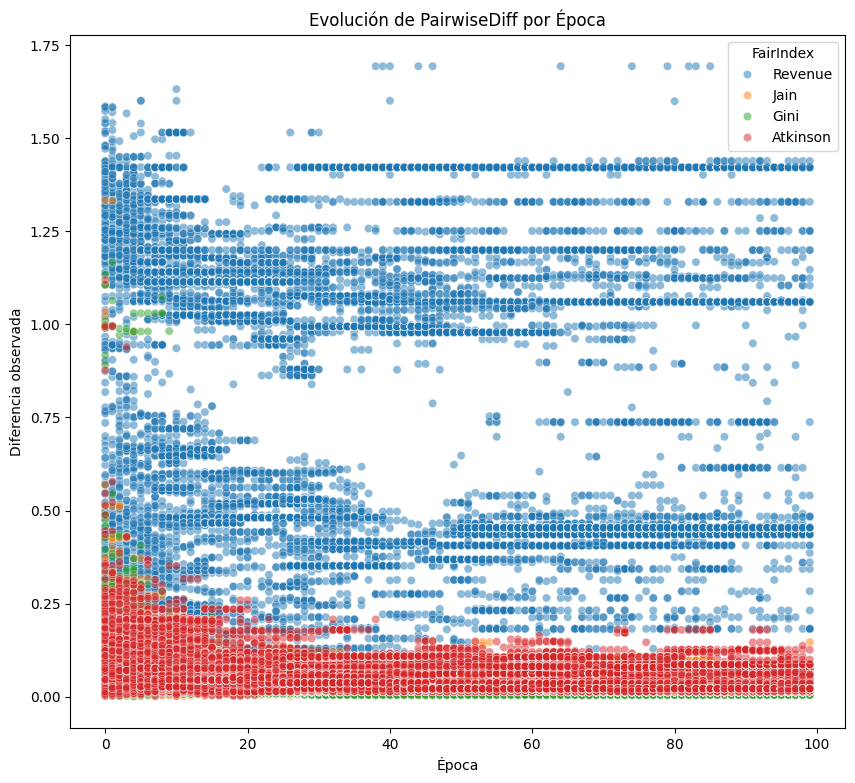

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))
sns.scatterplot(
    data=df_boxplot,
    x="Iteration",
    y="Fitness",
    hue="FairIndex",  # O también "Run" según te interese
    alpha=0.5
)
plt.title("Evolución de PairwiseDiff por Época")
plt.xlabel("Época")
plt.ylabel("Diferencia observada")
plt.show()


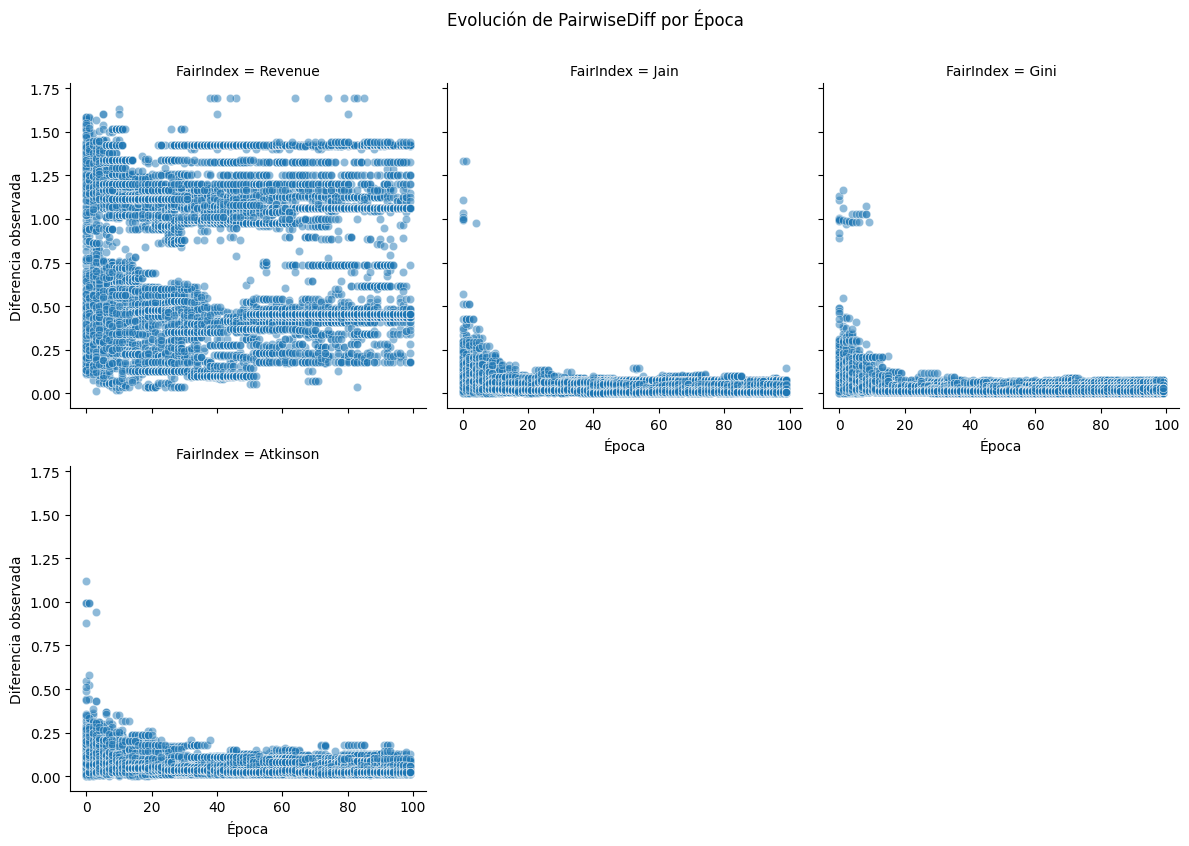

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creamos un FacetGrid: un subplot por cada valor único en 'FairIndex'
g = sns.FacetGrid(df_boxplot, col="FairIndex", col_wrap=3, height=4)
g.map(sns.scatterplot, "Iteration", "Fitness", alpha=0.5)

# Ajustamos etiquetas y título
g.set_axis_labels("Época", "Diferencia observada")
g.fig.suptitle("Evolución de PairwiseDiff por Época", y=1.05)

plt.show()

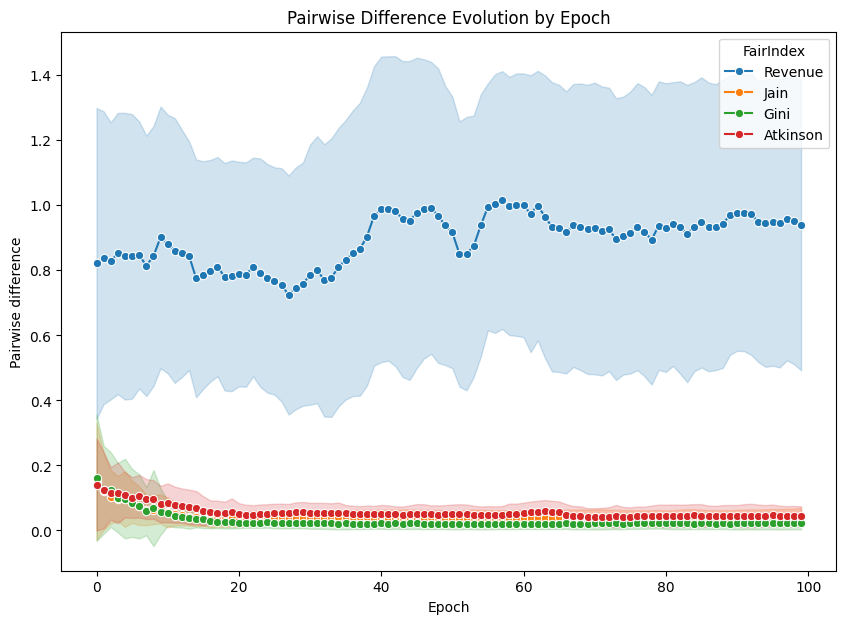

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=df_boxplot,
    x="Iteration",
    y="Fitness",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker="o"
)

plt.title("Pairwise Difference Evolution by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Pairwise difference")
plt.show()

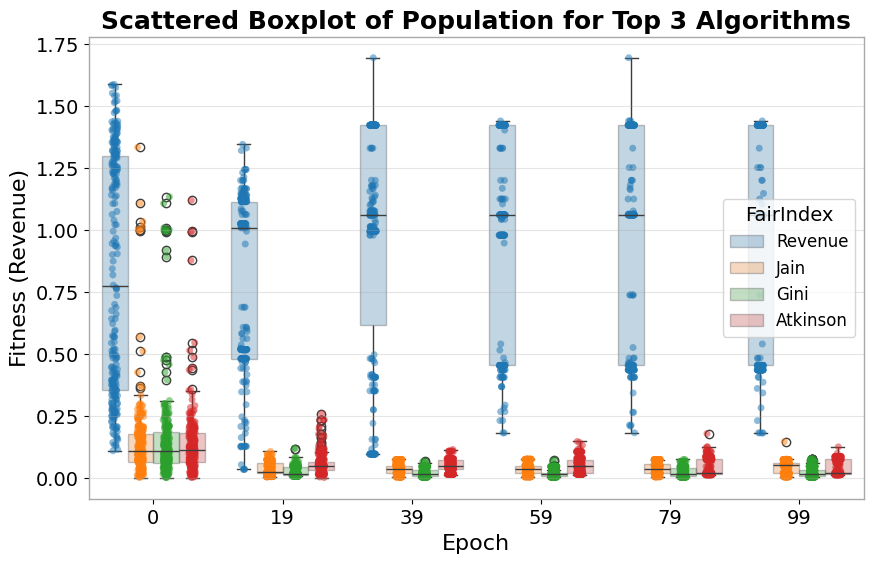

In [24]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='FairIndex',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25_equity.pdf'))

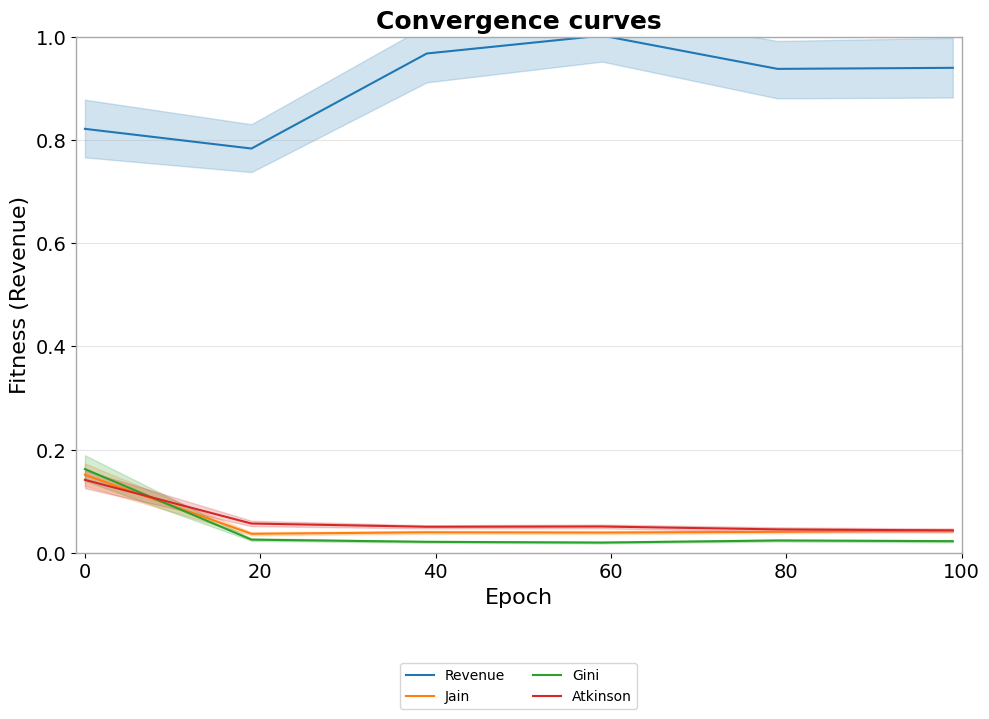

In [26]:
sns_line_plot(df=df_boxplot_filtered,
              x_data="Iteration",
              y_data="Fitness",
              hue="FairIndex",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(0,1),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity_pop.pdf'),
              fig_size=(10, 9))

In [14]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,586.730119,0.983922,[ True True False True False False False Tr...,"[1041, 1114, 1146, 1409, 1441, 1502, 1533, 159...",11.873798,0.000000,100.000000
1,1,Revenue,1,629.548587,1.012391,[ True True True True False False False Tr...,"[1006, 1114, 1147, 1409, 1449, 1497, 1539, 159...",10.012093,15.679106,84.320894
2,1,Revenue,2,659.900835,1.003813,[ True True False True False False False Tr...,"[1061, 1114, 1146, 1430, 1449, 1498, 1538, 159...",7.631318,35.729768,64.270232
3,1,Revenue,3,740.134037,0.994105,[ True True True True False False False Tr...,"[1041, 1114, 1147, 1409, 1441, 1497, 1539, 159...",6.515349,45.128352,54.871648
4,1,Revenue,4,850.172462,0.986817,[ True True True True False False False Tr...,"[1041, 1114, 1146, 1409, 1441, 1497, 1539, 159...",5.653798,52.384248,47.615752


In [15]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,586.730119,0.983922,"[True, True, False, True, False, False, False,...","[1041, 1114, 1146, 1409, 1441, 1502, 1533, 159...",11.873798,0.000000,100.000000
1,1,Revenue,1,629.548587,1.012391,"[True, True, True, True, False, False, False, ...","[1006, 1114, 1147, 1409, 1449, 1497, 1539, 159...",10.012093,15.679106,84.320894
2,1,Revenue,2,659.900835,1.003813,"[True, True, False, True, False, False, False,...","[1061, 1114, 1146, 1430, 1449, 1498, 1538, 159...",7.631318,35.729768,64.270232
3,1,Revenue,3,740.134037,0.994105,"[True, True, True, True, False, False, False, ...","[1041, 1114, 1147, 1409, 1441, 1497, 1539, 159...",6.515349,45.128352,54.871648
4,1,Revenue,4,850.172462,0.986817,"[True, True, True, True, False, False, False, ...","[1041, 1114, 1146, 1409, 1441, 1497, 1539, 159...",5.653798,52.384248,47.615752


In [17]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue"
)

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame:
# FairIndex, Run, Revenue, Execution Time (s.), Scheduled Trains + una columna por cada RU
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Pairwise Differences']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')

for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1], alpha=1)
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación (por si el método .sum_importance() depende de ello)
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Construir la fila de datos:
        row_data = [
            algo_key,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]

        # Agregar, para cada RU (ordenados alfabéticamente), el valor de suma de importancia.
        for ru in ru_names:
            # Si no existe valor para algún RU, se asigna 0
            row_data.append(importance_dict.get(ru, 0))

        # Agregar la columna de Total Importance
        row_data.append(total_importance)
        # Agregar la columna de Pairwise Differences
        row_data.append(pairwise_diff)

        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Pairwise Differences', ascending=True)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,Total Importance,Pairwise Differences
16,Revenue,2,1433.44,7167.195491,98.07,28,0.519750,0.710812,0.507617,1.738178,0.406390
18,Revenue,4,1419.30,7096.482607,99.35,29,0.565376,0.710333,0.492383,1.768093,0.435900
19,Revenue,5,1316.67,6583.355513,100.30,28,0.509279,0.719369,0.492383,1.721032,0.453972
8,Gini,4,1455.62,4773.103950,106.28,29,0.548404,0.789871,0.492383,1.830658,0.594975
10,Jain,1,1311.68,4359.369410,105.31,27,0.512936,0.812070,0.492383,1.817389,0.639373
3,Atkinson,4,1174.90,3521.670233,108.31,26,0.492577,0.833617,0.492383,1.818577,0.682468
5,Gini,1,1573.38,4901.503365,106.03,26,0.486498,0.833617,0.492383,1.812498,0.694239
1,Atkinson,2,1127.09,3790.696188,104.67,27,0.503165,0.846020,0.492383,1.841568,0.707273
0,Atkinson,1,1242.74,4924.727823,105.89,27,0.462319,0.826148,0.492383,1.780851,0.727657
7,Gini,3,1452.95,4367.964679,105.14,25,0.449532,0.833617,0.492383,1.775532,0.768171


In [20]:
# Table with results by run

mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index="Revenue")

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += sorted(set(service_tsps.values()))
columns += [f"{tsp}_equity" for tsp in sorted(set(service_tsps.values()))]
summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        mptt.update_schedule(real_solution)
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in sorted(service_tsps.values())}
        for i, service in enumerate(mptt.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(mptt.requested_schedule[service].keys())[0]
            delta_dt += abs(mptt.updated_schedule[service][departure_station][1] -
                            mptt.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(mptt.requested_schedule[service].keys()):
                if j == 0 or j == len(mptt.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(mptt.updated_schedule[service][stop][1] - mptt.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"

        frame_capacity_dict = {}
        for tsp in services_by_tsp:
            frame_capacity_dict[f"{tsp}_equity"] = f"{np.round(services_by_tsp[tsp] / 25 * 100, 2)}"

        row_data =  [algo_group[0],
                     run,
                     revenue,
                     execution_time,
                     scheduled_trains,
                     np.round(delta_dt, 2),
                     np.round(delta_tt, 2),
                     *list(percentages_by_tsp.values()),
                     *list(frame_capacity_dict.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,FairIndex,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU2,RU3,RU1_equity,RU2_equity,RU3_equity
6,Revenue,2,7167.20,99.26,28,395.0,181.0,50.0 %,73.33 %,50.0 %,64.0,44.0,4.0
8,Revenue,4,7096.48,102.10,29,463.0,192.0,56.25 %,66.67 %,50.0 %,72.0,40.0,4.0
5,Revenue,1,6798.94,101.98,26,380.0,184.0,43.75 %,66.67 %,100.0 %,56.0,40.0,8.0
9,Revenue,5,6583.36,101.05,28,357.0,190.0,50.0 %,73.33 %,50.0 %,64.0,44.0,4.0
7,Revenue,3,5955.93,100.14,27,294.0,138.0,50.0 %,73.33 %,0.0 %,64.0,44.0,0.0
1,Jain,2,5712.53,105.30,26,276.0,142.0,53.12 %,53.33 %,50.0 %,68.0,32.0,4.0
3,Jain,4,5193.51,104.48,24,252.0,122.0,46.88 %,53.33 %,50.0 %,60.0,32.0,4.0
2,Jain,3,5177.93,104.51,24,149.0,94.0,53.12 %,40.0 %,50.0 %,68.0,24.0,4.0
0,Jain,1,4997.63,106.62,23,168.0,77.0,46.88 %,46.67 %,50.0 %,60.0,28.0,4.0
4,Jain,5,4833.82,103.70,23,225.0,78.0,50.0 %,40.0 %,50.0 %,64.0,24.0,4.0


In [ ]:
frame_capacity

In [ ]:
# Supongamos que frame_capacity_target es un diccionario como:

sm = RevenueMaximization(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10
)

# Diccionario para relacionar cada servicio con el nombre de su RU.
service_tsps = {service.id: service.tsp.name for service in supply.services}

# Definir las columnas del dataframe de resumen.
base_columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)',
                'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)', 'Overall Fairness']
# Ordenamos alfabéticamente los nombres de RU
ru_names = sorted(set(service_tsps.values()))
# Se añaden columnas con el porcentaje alcanzado (a nivel de RU) y
# columnas informativas con el nombre _equity para cada RU.
summary_columns = base_columns + ru_names + [f"{tsp}_equity" for tsp in ru_names]
summary_df = pd.DataFrame(columns=summary_columns)

# Agrupamos df_history por FairIndex (cada grupo corresponde a un método/algoritmo)
algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for run_label, run_group in run_grouped_df:
        # Extraer valores de la ejecución
        run = run_group['Run'].iloc[-1]
        revenue = np.round(run_group['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizar la planificación con la solución real (se ignoran los servicios no programados)
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains_array))
        delta_dt = 0.0
        delta_tt = 0.0

        # Inicializar contadores para cada RU (por ejemplo, 'RU1', 'RU2', etc.)
        services_by_tsp = {tsp: 0 for tsp in ru_names}

        # Para cada servicio del plan solicitado, si está programado se acumulan los deltas y se cuenta la RU
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            # Para el primer stop se calcula el delta en DT
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(
                sm.updated_schedule[service][departure_station][1] -
                sm.requested_schedule[service][departure_station][1]
            )
            # Para los stops intermedios se acumulan los deltas en TT
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(
                    sm.updated_schedule[service][stop][1] -
                    sm.requested_schedule[service][stop][1]
                )
            # Incrementar contador según el RU del servicio
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1

        # Calcular el porcentaje alcanzado para cada RU comparando con su capacidad marco.
        # Por ejemplo, si para 'RU1' se programaron 15 servicios y la capacidad marco es 30, se alcanza el 50%.
        percentages_by_tsp = {}
        ru_equity = {}  # Almacenará el valor numérico (por ejemplo, 50.0) para cada RU
        for tsp in ru_names:
            target = services_by_ru[tsp]  # capacidad marco del RU
            achieved = services_by_tsp[tsp]
            percentage = np.round(achieved / target * 100, 2) if target != 0 else 0.0
            percentages_by_tsp[tsp] = f"{percentage} %"
            ru_equity[tsp] = percentage

        # Calcular el índice de equidad global (Overall Fairness) usando la fórmula de Jain:
        # J = (sum(r_i)^2) / (n * sum(r_i^2))
        r_values = list(ru_equity.values())
        n = len(r_values)
        sum_r = sum(r_values)
        sum_r_sq = sum([r**2 for r in r_values])
        overall_fairness = (sum_r**2) / (n * sum_r_sq) if sum_r_sq != 0 else 0

        # Preparar la fila de datos. Se agregan:
        # - Las métricas generales
        # - Para cada RU, el porcentaje alcanzado (según el orden en ru_names)
        # - Para cada RU, se incluye una columna con el nombre <RU>_equity que muestra el mismo valor numérico
        row_data = [
            algo_group[0],            # FairIndex (método)
            run,
            revenue,
            execution_time,
            scheduled_trains,
            np.round(delta_dt, 2),
            np.round(delta_tt, 2),
            np.round(overall_fairness, 4)  # Se puede multiplicar por 100 si se prefiere porcentaje
        ]
        # Agregar los porcentajes por RU
        for tsp in ru_names:
            row_data.append(percentages_by_tsp[tsp])
        # Agregar las columnas de _equity (se puede mostrar el valor numérico)
        for tsp in ru_names:
            row_data.append(ru_equity[tsp])

        # Añadir la fila al dataframe resumen
        summary_df.loc[len(summary_df)] = row_data

# Ordenar el dataframe de salida según el Overall Fairness de forma descendente
summary_df = summary_df.sort_values('Overall Fairness', ascending=False)
display(summary_df)
print()


In [ ]:
summary_df.to_latex()

In [ ]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

In [ ]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

In [ ]:
results_df.to_latex()

In [ ]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity.pdf'),
              fig_size=(10, 9))

In [ ]:
df_history.head()

In [ ]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [ ]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

In [ ]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

In [ ]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 1
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

In [ ]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [ ]:
final_supply = Supply.from_yaml(supply_config_file)

In [ ]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [ ]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_equity.yml')

In [ ]:
#!snakeviz profile.pstat